# Newsletter Content Recommendation System with lightFM</font>

## Table of Contents

* [<font color='#24bfeb'>1. Target definition </font>](#chapter1)


* [<font color='#24bfeb'>2. Algorithm implementation </font>](#chapter2)

    * [<font color='#24bfeb'>2.1. Project initiation</font>](#section_2_1)
        * [<font color='#24bfeb'>2.1.1 Reestart the session</font>](#section_2_1_1)
        * [<font color='#24bfeb'>2.1.2 Import libraries</font>](#section_2_1_2) 

    * [<font color='#24bfeb'>2.2. Data preprocessing</font>](#section_2_2)

        * [<font color='#24bfeb'>2.2.1 Import data</font>](#section_2_2_1)
        * [<font color='#24bfeb'>2.2.2 Exploratory data analysis</font>](#section_2_2_2)
        * [<font color='#24bfeb'>2.2.3 Missing data</font>](#section_2_2_3)
        * [<font color='#24bfeb'>2.2.4 Outlier detection</font>](#section_2_2_4)
        * [<font color='#24bfeb'>2.2.5 Categorical features</font>](#section_2_5)
            * [<font color='#24bfeb'>2.2.5.1 Identify unique values</font>](#sub_section_2_2_5_1)
            * [<font color='#24bfeb'>2.2.5.2 One-Hot encoding</font>](#sub_section_2_2_5_2)
        * [<font color='#24bfeb'>2.2.6 Feature engineering</font>](#section_2_2_6)
        
        * [<font color='#24bfeb'>2.2.7 Feature scaling</font>](#section_2_2_7)

    * [<font color='#24bfeb'>2.3. Model selection</font>](#section_2_3)
        * [<font color='#24bfeb'>2.3.1 Initial considerations</font>](#section_2_3_1)
        * [<font color='#24bfeb'>2.3.2 Metric selection</font>](#section_2_3_2)
        
    * [<font color='#24bfeb'>2.4 Implementation</font>](#section_2_4)

    * [<font color='#24bfeb'>2.5 Model improvement</font>](#section_2_5)

    * [<font color='#24bfeb'>2.6 Model deployment</font>](#section_2_6)


* [<font color='#24bfeb'>3. System evolution </font>](#chapter3)


* [<font color='#24bfeb'>4. UX tools alternatives </font>](#chapter4)


* [<font color='#24bfeb'>5. Model feature selection</font>](#chapter5)


* [<font color='#24bfeb'>6. Next steps: computer vision and text mining </font>](#chapter6)

# 1. Target definition <a class="anchor" id="chapter1"></a>
1. Target definition 
The purpose of our solution is to increase the volume of sales of a Pharma company products. We do not have final sales by prescription from the doctors and we believe that knowledge of our brand drives sales in a long term. Based on the data that are provided to you, first we need to think what target we could select or create to optimize for long term sales increase¶

As our goal is to **increase the prescription of drugs by doctors 'Message_click' is the most important rate** to optimize, because altough we do not have doctor's prescriptions data it does make sense to believe that there is a positive correlation between HCP's clicks to obtain more information and prescriptions.

Besides, although it is not as important as 'message_click', I think that we should also take into consideration if the **HCP has read the message. **In order to combine both we will create a weighted mean of click and read, putting the 80% of the weight in the first one**. The formula for our target will result as:

$$ target = 0.8 * Messageclick + 0.2 * Messageread$$

# 2. Algorithm implementation <a class="anchor" id="chapter2"></a>
### Based on the data you are provided, we will develop an algorithm to recommend  how to interact with HCPs in terms of newsletter and messages

## 2.1. Project initiation <a class="anchor" id="section_2_1"></a>

### 2.1.1 Reestart the session  <a class="anchor" id="section_2_1_1"></a>
It’s a good practice to restart the session and to remove all the temporary variables from the interactive development environment before we start coding

In [1]:
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

### 2.1.2 Import libraries and basic configuration  <a class="anchor" id="section_2_1_2"></a>


In [2]:
#pip install lightfm

In [3]:
#pip install scikit-optimize

In [4]:
import pandas as pd
import numpy as np
from scipy import stats 

# sklearn modules for data preprocessing:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

#sklearn modules for Model Selection:
from sklearn.ensemble import RandomForestClassifier

from skopt import forest_minimize

#Standard libraries for data visualization:
import seaborn as sn
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

from skopt import forest_minimize
from lightfm import LightFM, cross_validation
from lightfm import evaluation
from lightfm.evaluation import auc_score
from lightfm.data import Dataset
from scipy import sparse
from tqdm import tqdm

import joblib

/Users/lauraruizmartinez/opt/anaconda3/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## 2.2 Data preprocessing <a class="anchor" id="#section_2_2"></a>
Before doing any preprocessing, we will take a look at the data to understand the data to acknowledge the potential problems we are dealing with. In order to accomplish our purpose we will check distribution of the variables, presence of nulls, column types, etc..

### 2.2.1 Import the dataset <a class="anchor" id="section_2_2_1"></a>

In [5]:
df = pd.read_csv('./data/data_usecase_encoded.csv', sep=';')

In [6]:
df.head()

,HCP_id,news_id,Message_id,Message_type,Message_creation_date,Message_TA,news_date,office_or_hospital_based,gender,is_cardiologist,is_gp,years_since_graduation,Message_read,Message_click
0,3569,22,71,Biotech,10/12/19,Cardio Vascular,8/9/20,Hospital,False,True,False,10.0,1,0
1,3569,22,70,Biotech,7/31/18,Global,8/9/20,Hospital,False,True,False,10.0,0,0
2,5941,22,70,Biotech,7/31/18,Global,8/9/20,Hospital,True,True,False,10.0,1,1
3,5941,22,71,Biotech,10/12/19,Cardio Vascular,8/9/20,Hospital,True,True,False,10.0,1,1
4,8262,5,19,Biotech,10/12/18,Cardio Vascular,7/22/20,Office,True,True,False,10.0,0,0


### 2.2.2 Exploratory data analysis  <a class="anchor" id="section_2_2_2"></a>

In this section, we need to look at the dataset in general and each column in detail to get a better understanding of the input data.


From the head & column methods, we get an idea that this dataset contains information redarging the
messages sent to HCPs through newsletters and information about the HCP, the newsletter and the
message.

In [7]:
df.head()

,HCP_id,news_id,Message_id,Message_type,Message_creation_date,Message_TA,news_date,office_or_hospital_based,gender,is_cardiologist,is_gp,years_since_graduation,Message_read,Message_click
0,3569,22,71,Biotech,10/12/19,Cardio Vascular,8/9/20,Hospital,False,True,False,10.0,1,0
1,3569,22,70,Biotech,7/31/18,Global,8/9/20,Hospital,False,True,False,10.0,0,0
2,5941,22,70,Biotech,7/31/18,Global,8/9/20,Hospital,True,True,False,10.0,1,1
3,5941,22,71,Biotech,10/12/19,Cardio Vascular,8/9/20,Hospital,True,True,False,10.0,1,1
4,8262,5,19,Biotech,10/12/18,Cardio Vascular,7/22/20,Office,True,True,False,10.0,0,0


In [8]:
df.columns

Index(['HCP_id', 'news_id', 'Message_id', 'Message_type',
       'Message_creation_date', 'Message_TA', 'news_date',
       'office_or_hospital_based', 'gender', 'is_cardiologist', 'is_gp',
       'years_since_graduation', 'Message_read', 'Message_click'],
      dtype='object')

It seems to have duplicate registers. It is a common practice to remove duplicates. However, in this case we will not remove it as we can not be sure that those are actually mistakes. In this specific case we will treat as if the same HCP has received more than one time the same newsletter or message, which could provide predictive power itself.

In [9]:
print('# of registers before removing duplicates: ', df.count())
print('# of registers after removing duplicates: ', df.drop_duplicates().count())

# of registers before removing duplicates:  HCP_id                      55543
news_id                     55543
Message_id                  55543
Message_type                55543
Message_creation_date       55543
Message_TA                  55543
news_date                   55543
office_or_hospital_based    55509
gender                      55543
is_cardiologist             55543
is_gp                       55543
years_since_graduation      55537
Message_read                55543
Message_click               55543
dtype: int64
# of registers after removing duplicates:  HCP_id                      55152
news_id                     55152
Message_id                  55152
Message_type                55152
Message_creation_date       55152
Message_TA                  55152
news_date                   55152
office_or_hospital_based    55118
gender                      55152
is_cardiologist             55152
is_gp                       55152
years_since_graduation      55146
Message_read    

Now we will use the **describe** method to show **basic statistic information of each numerical column** of the dataset. This shows us and interesting first overview:
- HDP_id news_id and message_id are identifiers so it does not make much sense to look at the statistical indicators
- HCP years since graduation is 27.2, although values goes from 3 to 68
- Mean of message read is 0.5 altough the messages click decreases to 0.26

In [10]:
df.describe()

,HCP_id,news_id,Message_id,years_since_graduation,Message_read,Message_click
count,55543.000000,55543.000000,55543.000000,55537.000000,55543.000000,55543.000000
mean,4170.103055,15.428731,50.671210,27.137620,0.504924,0.260123
std,2411.556208,8.718147,28.834948,12.367719,0.499980,0.438705
min,1.000000,1.000000,1.000000,3.000000,0.000000,0.000000
25%,2091.500000,8.000000,26.000000,17.000000,0.000000,0.000000
50%,4182.000000,17.000000,51.000000,28.000000,1.000000,0.000000
75%,6256.500000,24.000000,76.000000,37.000000,1.000000,1.000000
max,8349.000000,30.000000,100.000000,68.000000,1.000000,1.000000


Now let's look for **column types** and **missing values**. The dataset has 55543 registers and 14 columns. In addition, both categorical and numerical columns have missing values.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55543 entries, 0 to 55542
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   HCP_id                    55543 non-null  int64  
 1   news_id                   55543 non-null  int64  
 2   Message_id                55543 non-null  int64  
 3   Message_type              55543 non-null  object 
 4   Message_creation_date     55543 non-null  object 
 5   Message_TA                55543 non-null  object 
 6   news_date                 55543 non-null  object 
 7   office_or_hospital_based  55509 non-null  object 
 8   gender                    55543 non-null  bool   
 9   is_cardiologist           55543 non-null  bool   
 10  is_gp                     55543 non-null  bool   
 11  years_since_graduation    55537 non-null  float64
 12  Message_read              55543 non-null  int64  
 13  Message_click             55543 non-null  int64  
dtypes: boo

Now it's time to check the proportion of **null values** for each column. This dataset is pretty well informed, only 'office_or_hospital_based' and 'years_since_graduation' present an small proportion of null values which is no significant

In [12]:
NA = pd.DataFrame(data=[df.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
            for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
            columns=df.columns, index=['NA Count', 'NA Percent']).T.\
            sort_values(by='NA Count',ascending =False)

NA.style.background_gradient(cmap='Blues_r', subset=['NA Count'])

,NA Count,NA Percent
office_or_hospital_based,34,0.06%
years_since_graduation,6,0.01%
HCP_id,0,0.00%
news_id,0,0.00%
Message_id,0,0.00%
Message_type,0,0.00%
Message_creation_date,0,0.00%
Message_TA,0,0.00%
news_date,0,0.00%
gender,0,0.00%


In the **correlation matrix** we can observe that **'Message_read' is the most coorelated variables with 'Message_click'**

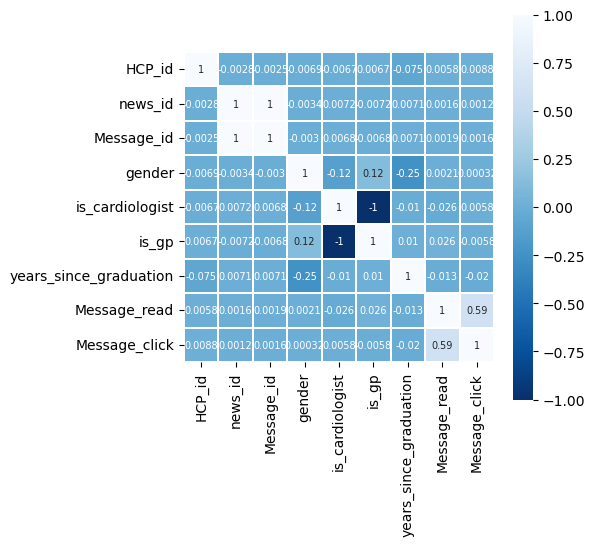

In [13]:
corrmat = df.corr()
fig, ax = plt.subplots(figsize = (5,5))
ax = sn.heatmap(corrmat, cmap='Blues_r', square=True, linewidths=0.1, annot=True, annot_kws={"fontsize":7})  

In [14]:
df.head()

,HCP_id,news_id,Message_id,Message_type,Message_creation_date,Message_TA,news_date,office_or_hospital_based,gender,is_cardiologist,is_gp,years_since_graduation,Message_read,Message_click
0,3569,22,71,Biotech,10/12/19,Cardio Vascular,8/9/20,Hospital,False,True,False,10.0,1,0
1,3569,22,70,Biotech,7/31/18,Global,8/9/20,Hospital,False,True,False,10.0,0,0
2,5941,22,70,Biotech,7/31/18,Global,8/9/20,Hospital,True,True,False,10.0,1,1
3,5941,22,71,Biotech,10/12/19,Cardio Vascular,8/9/20,Hospital,True,True,False,10.0,1,1
4,8262,5,19,Biotech,10/12/18,Cardio Vascular,7/22/20,Office,True,True,False,10.0,0,0


We have observed that we have three bool variables that are actually binary features, so we will map it in order to study it.

In [15]:
df['gender'] = df['gender'].replace(True, 1).replace(False, 0)
df['is_cardiologist'] = df['is_cardiologist'].replace(True,1).replace(False, 0)
df['is_gp'] = df['is_gp'].replace(True,1).replace(False, 0)
df['office_or_hospital_based'] = df['office_or_hospital_based'].replace('Hospital',1).replace('Office', 0)

**Find positive and negative correlations with click.** Let’s have a look into the positive and negative correlations. None of the variables seem to be strongly correlated with click. We will try to create new features in order to obtain good predictors

In [16]:
df.dtypes

HCP_id                        int64
news_id                       int64
Message_id                    int64
Message_type                 object
Message_creation_date        object
Message_TA                   object
news_date                    object
office_or_hospital_based    float64
gender                        int64
is_cardiologist               int64
is_gp                         int64
years_since_graduation      float64
Message_read                  int64
Message_click                 int64
dtype: object

In [17]:
correlations = df.corrwith(df.Message_click)
correlations = correlations[correlations!=1]
positive_correlations = correlations[
correlations >0].sort_values(ascending = False)
negative_correlations =correlations[
correlations<0].sort_values(ascending = True)
print('Most Positive Correlations: \n', positive_correlations)
print('\nMost Negative Correlations: \n', negative_correlations)

Most Positive Correlations: 
 Message_click      1.000000
Message_read       0.587127
HCP_id             0.008834
is_cardiologist    0.005779
Message_id         0.001552
news_id            0.001213
gender             0.000321
dtype: float64

Most Negative Correlations: 
 years_since_graduation     -0.019654
is_gp                      -0.005779
office_or_hospital_based   -0.000330
dtype: float64


**Plot positive & negative correlations:**

Text(0.5, 1.0, 'Correlation with Message click \n')

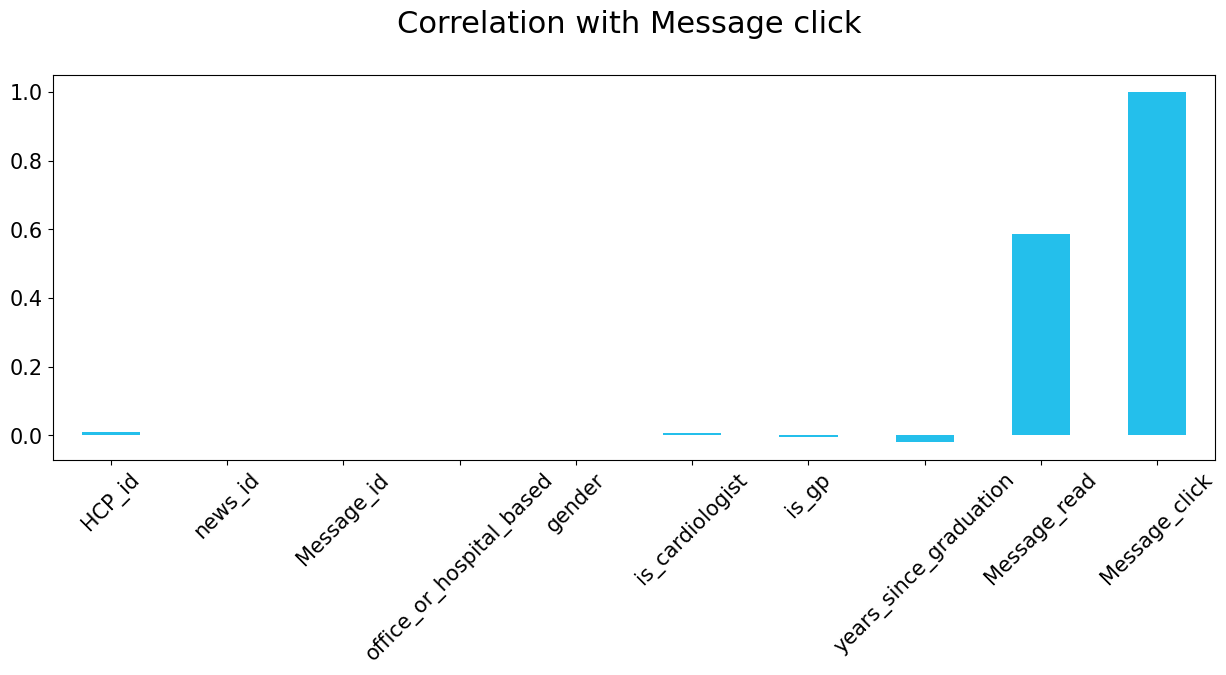

In [18]:
correlations = df.corrwith(df.Message_click)
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (15, 5), 
        fontsize = 15, 
        color = '#24bfeb',
        rot = 45, grid = False)
plt.title('Correlation with Message click \n', horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")

Finally we will plot the **histogram** to check numerical variables **distribution**.  

array([[<AxesSubplot:title={'center':'office_or_hospital_based'}>,
        <AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'is_cardiologist'}>],
       [<AxesSubplot:title={'center':'is_gp'}>,
        <AxesSubplot:title={'center':'years_since_graduation'}>,
        <AxesSubplot:title={'center':'Message_read'}>],
       [<AxesSubplot:title={'center':'Message_click'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

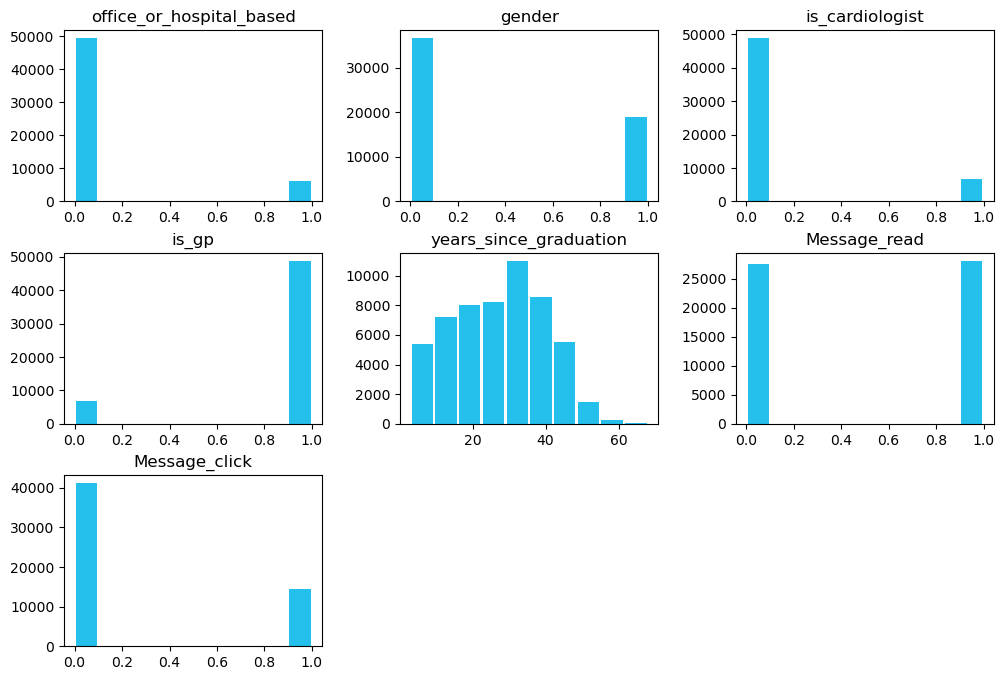

In [19]:
df_aux = df.drop(['HCP_id', 'news_id', 'Message_id'], axis=1)
df_aux.hist(bins=10, grid=False, figsize=(12,8), color='#24bfeb', zorder=2, rwidth=0.9)

Same for categorical variables. 

['Message_type', 'Message_TA']


/var/folders/1p/tlnbdqdx6hqd3pmx9m8c8pv80000gn/T/ipykernel_15796/3585081406.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


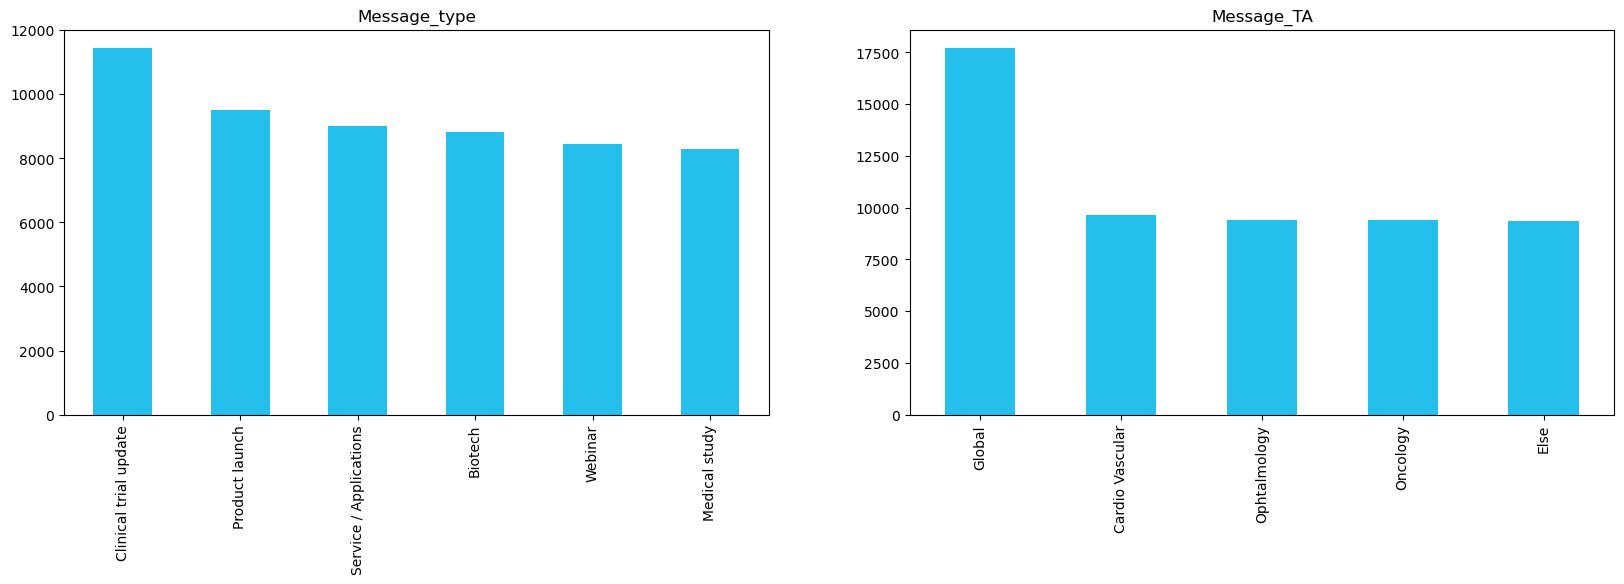

In [20]:
categorical_features = df.select_dtypes(include='object').columns.to_list()
categorical_features.remove('Message_creation_date')
categorical_features.remove('news_date')
print(categorical_features)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
for i, categorical_feature in enumerate(df[categorical_features]):
    df[categorical_feature].value_counts().plot(kind="bar", ax=ax[i], color='#24bfeb').set_title(categorical_feature)
fig.show()

Now let's analyze **HCP proportion that clicked to get more information**

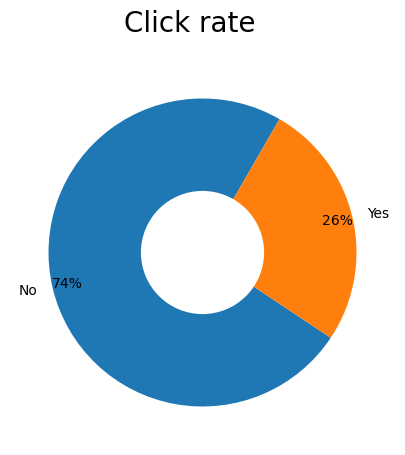

In [21]:
fig, ax  = plt.subplots(figsize=(10, 5))
fig.suptitle('Click rate', size = 20, color = "black")
explode = ( 0.05, 0.3)
labels = ["No", "Yes"]
sizes = df["Message_click"].dropna().value_counts()
ax.pie(sizes,
       startangle=60,
       labels=labels,
       autopct='%1.0f%%',
       pctdistance=0.9)
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

The final step of the EDA will consist on **analyzing the click rate distribution by categorical variables.** Medical study and product launch related messages and cardiovascular type appear to have slightly higher message click rates. There is no significant differences in the rest of the categorical variables in terms of message clicks

In [25]:
def click_rate_by(column):
    click_rate = df.groupby([column,'Message_click']).size().unstack()
    ax = (click_rate.T*100.0 / click_rate.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot=0,
                                                          figsize = (6,3))
    plt.ylabel('Proportion of HCPs\n',
    horizontalalignment="center",fontstyle = "normal", 
    fontsize = "large", fontfamily = "sans-serif")
    plt.xlabel(column + '\n',horizontalalignment="center",
    fontstyle = "normal", fontsize = "large", 
    fontfamily = "sans-serif")
    plt.title('Click rate by ' + column + '\n',
    horizontalalignment="center", fontstyle = "normal", 
    fontsize = "18", fontfamily = "sans-serif")
    plt.legend(loc='upper right', fontsize = "medium")
    plt.xticks(rotation=45, horizontalalignment="center")
    plt.yticks(rotation=0, horizontalalignment="right")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f}%'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center')
    ax.autoscale(enable=False, axis='both', tight=False)

In [26]:
features = ['Message_type', 'Message_TA', 
            'office_or_hospital_based', 'gender',
            'is_cardiologist', 'is_gp', 'Message_read']

[None, None, None, None, None, None, None]

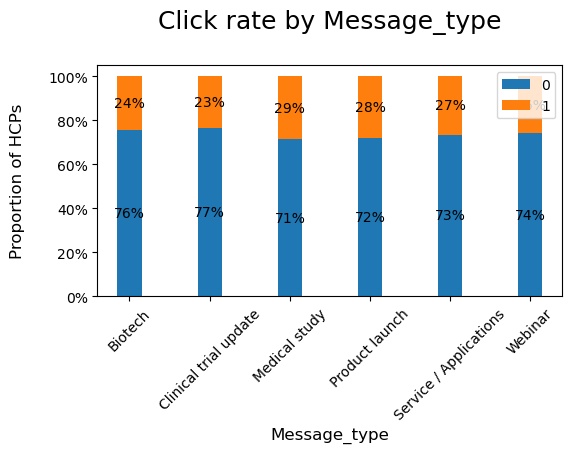

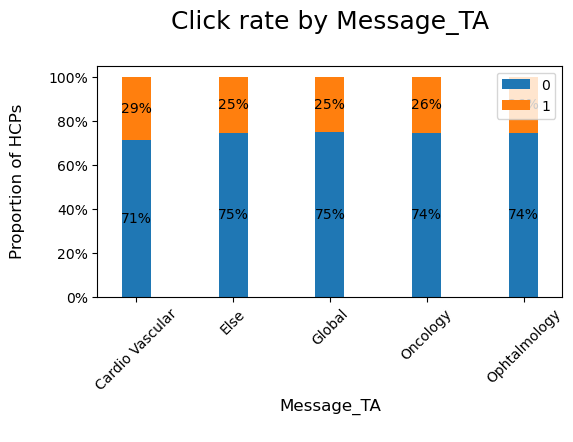

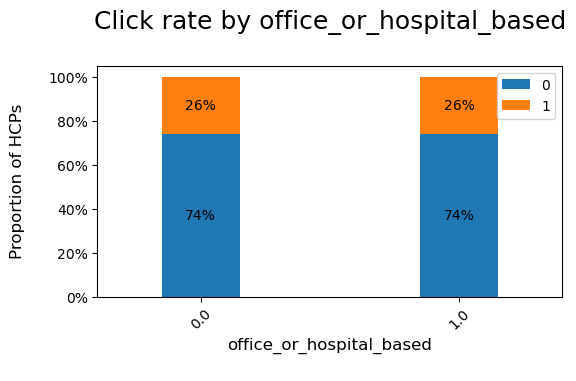

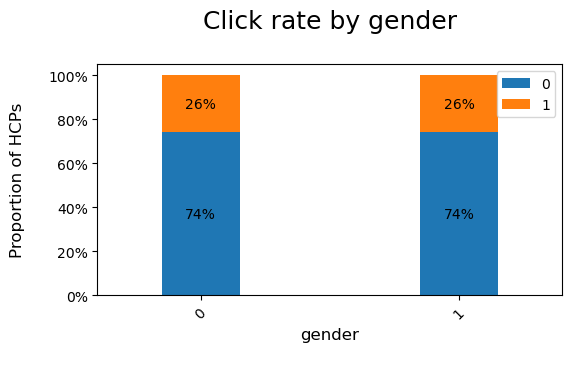

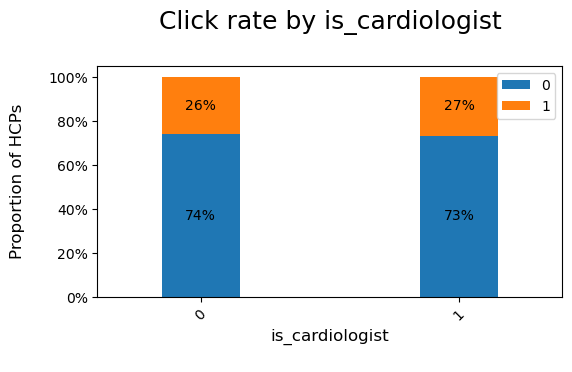

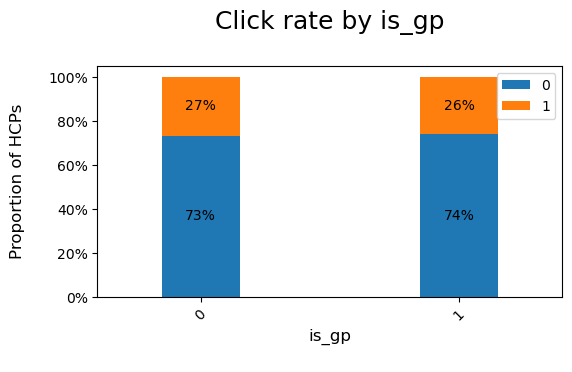

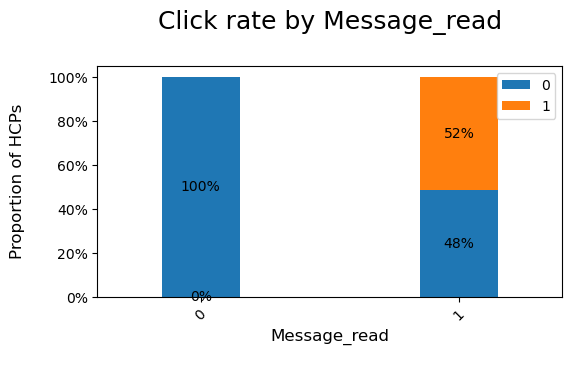

In [27]:
[click_rate_by(column) for column in features]

Finally, in order to develop an algorithm to recommend to the company how to interact with HCPs in terms of newsletter and messages, it is important to **understand which variables are related to the newsletters and messages and which ones are descriptive information to characterize HCPs.**

As we see we have information of **30 newsletters, each of them containing up to 8 different messages of different types**. The creation time of both newsletter and message are also provided.

Text(0.5, 1.0, 'Number of messages per newsletter')

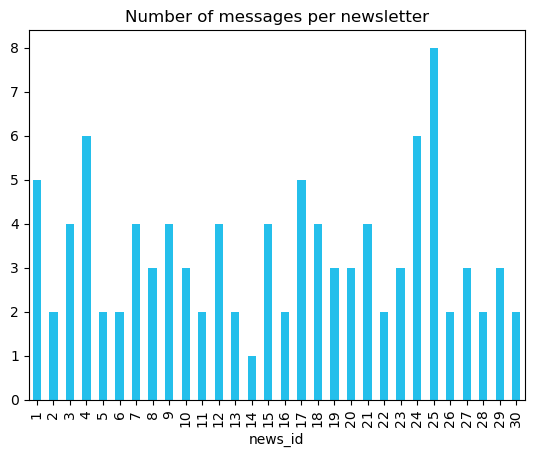

In [28]:
df.groupby(['news_id']).Message_id.nunique().plot(kind="bar", color='#24bfeb').set_title('Number of messages per newsletter')

In [29]:
df.groupby(['news_id', 'Message_id', 'Message_type', 'Message_TA', 'Message_click']).count()

HCP_id  \
news_id Message_id Message_type           Message_TA   Message_click           
1       1          Service / Applications Else         0                 398   
                                                       1                 136   
        2          Product launch         Ophtalmology 0                 387   
                                                       1                 147   
        3          Clinical trial update  Else         0                 414   
...                                                                      ...   
29      98         Service / Applications Oncology     1                 151   
30      99         Clinical trial update  Global       0                 426   
                                                       1                 135   
        100        Product launch         Else         0                 420   
                                                       1                 141   

                                                                      Message_creation_date  \
news_id Message_id Message_type           Message_TA   Message_click                          
1       1          Service / Applications Else         0                                398   
                                                       1                                136   
        2          Product launch         Ophtalmology 0                                387   
                                                       1                                147   
        3          Clinical trial update  Else         0                                414   
...                                                                                     ...   
29      98         Service / Applications Oncology     1                                151   
30      99         Clinical trial update  Global       0                                426   
                                                       1                                135   
        100        Product launch         Else         0                                420   
                                                       1                                141   

                                                                      news_date  \
news_id Message_id Message_type           Message_TA   Message_click              
1       1          Service / Applications Else         0                    398   
                                                       1                    136   
        2          Product launch         Ophtalmology 0                    387   
                                                       1                    147   
        3          Clinical trial update  Else         0                    414   
...                                                                         ...   
29      98         Service / Applications Oncology     1                    151   
30      99         Clinical trial update  Global       0                    426   
                                                       1                    135   
        100        Product launch         Else         0                    420   
                                                       1                    141   

                                                                      office_or_hospital_based  \
news_id Message_id Message_type           Message_TA   Message_click                             
1       1          Service / Applications Else         0                                   398   
                                                       1                                   136   
        2          Product launch         Ophtalmology 0                                   387   
                                                       1                                   147   
        3          Clinical trial update  Else         0                                   414   
...                        

### 2.2.3 Missing data <a class="anchor" id="section_2_2_3"></a>

#### 2.2.3.1 Numerical columns <a class="anchor" id="sub_section_2_2_3_1"></a>
We have missing values in some of the numeric columns of the dataset. We will **fill** their **missing values with average of each column.**

In [30]:
def filling_nulls_with_mean(df):
    na_cols = df.isna().any()
    na_cols = na_cols[na_cols == True].reset_index()
    na_cols = na_cols["index"].tolist()
    print('Columns with null values: ', na_cols)
    for col in df.columns[1:]:
         if col in na_cols:
            if df[col].dtype != 'object':
                 df[col] =  df[col].fillna(df[col].mean()).round(0)
    return df

In [31]:
df = filling_nulls_with_mean(df)

Columns with null values:  ['office_or_hospital_based', 'years_since_graduation']


Now we check that the numerical columns with null values have been filled

In [32]:
df.isna().any()

HCP_id                      False
news_id                     False
Message_id                  False
Message_type                False
Message_creation_date       False
Message_TA                  False
news_date                   False
office_or_hospital_based    False
gender                      False
is_cardiologist             False
is_gp                       False
years_since_graduation      False
Message_read                False
Message_click               False
dtype: bool

### 2.2.4 Outlier detection  <a class="anchor" id="section_2_2_4"></a>
There are multiple reasons why there can be outliers in the dataset, like Human errors(Wrong data entry), Measurement errors(System/Tool error), Data manipulation error(Faulty data preprocessing error), Sampling errors(creating samples from heterogeneous sources), etc. Detecting and treating these Outliers is important for learning a robust and generalizable machine learning system.

We will review briefly the most used outlier detection techniques:

- **Z-score**: The Z-score(also called the standard score) is an important concept in statistics that indicates how far away a certain point is from the mean. By applying Z-transformation we shift the distribution and make it 0 mean with unit standard deviation. For example — A Z-score of 2 would mean the data point is 2 standard deviation away from the mean. It assumes that the data is normally distributed and hence the % of data points that lie between -/+1 stdev. is ~68%, -/+2 stdev. is ~95% and -/+3 stdev. is ~99.7%. Hence, if the Z-score is >3 we can safely mark that point to be an outlier.


- **Inter-Quartile Range Method**: The interquartile range method, best shown using a box plot, divides data into quartiles by defining three points:

    - Quartile 1 (Q1) represents 25th percentile
    - Quartile 2 (Q2) represents 50th percentile
    - Quartile 3 (Q3) represents 75th percentile

    The box in the boxplot represents the IQR range which is defined as the range between Q1 and Q3; IQR = Q3 — Q1 and data points that fall below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are defined as outliers.
    
- **Automatic Outlier Detection**: In machine learning, an approach to tackling the problem of outlier detection is one-class classification. One-Class Classification, or OCC for short, involves fitting a model on the 'normal' data and predicting whether new data is normal or an outlier/anomaly. Examples of this are:
    - Local Outlier Factor
    - Isolation Forest




In [33]:
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns.to_list()

In [34]:
numerical_df = df[numerical_features]
outlier_df = numerical_df[(np.abs(stats.zscore(numerical_df)) < 3).all(axis=1)]

In [35]:
df = pd.merge(df, outlier_df, how='inner')

#### 2.2.5 Categorical features <a class="anchor" id="section_2_2_5"></a>

In this case we are dealing with multiple categorical features can assume that **all variables are nominal**, which basicly means that do not have a particular order so I will opt for **One-hot Encoding** or Frequency Encoding.


In [36]:
categorical_features

['Message_type', 'Message_TA']

#### 2.2.5.1 Identify unique values <a class="anchor" id="sub_section_2_2_5_1"></a>

We have 3 different categorical column in the dataset. First of all, let's see how many different values take each category in order to choose the best treatment for each of them. As the number of possibilities are up to 6, we will apply One-Hot encoding.

In [37]:
for feat in categorical_features:
    print('Number of different ' + feat + ':', df[feat].nunique())

Number of different Message_type: 6
Number of different Message_TA: 5


#### 2.2.5.2 One-Hot encoding <a class="anchor" id="sub_section_2_2_5_2"></a>

we are ready to apply **pandas get_dummies() method** to get dummy variables.

In [38]:
df = pd.get_dummies(df, columns=categorical_features)
df.columns = df.columns.str.replace(' ', '').str.strip().str.lower()

In [39]:
df.head()

,hcp_id,news_id,message_id,message_creation_date,news_date,office_or_hospital_based,gender,is_cardiologist,is_gp,years_since_graduation,message_read,message_click,message_type_biotech,message_type_clinicaltrialupdate,message_type_medicalstudy,message_type_productlaunch,message_type_service/applications,message_type_webinar,message_ta_cardiovascular,message_ta_else,message_ta_global,message_ta_oncology,message_ta_ophtalmology
0,3569,22,71,10/12/19,8/9/20,1.0,0,1,0,10.0,1,0,1,0,0,0,0,0,1,0,0,0,0
1,3569,22,70,7/31/18,8/9/20,1.0,0,1,0,10.0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,5941,22,70,7/31/18,8/9/20,1.0,1,1,0,10.0,1,1,1,0,0,0,0,0,0,0,1,0,0
3,5941,22,71,10/12/19,8/9/20,1.0,1,1,0,10.0,1,1,1,0,0,0,0,0,1,0,0,0,0
4,8262,5,19,10/12/18,7/22/20,0.0,1,1,0,10.0,0,0,1,0,0,0,0,0,1,0,0,0,0


### 2.2.6 Feature engineering <a class="anchor" id="section_2_2_6"></a>

#### 2.2.6.1 Dates <a class="anchor" id="section_2_2_6_1"></a>

In [40]:
def create_fe_dates(df: pd.DataFrame) -> pd.DataFrame:
    
    # convert to datetime
    df['message_creation_date'] = pd.to_datetime(df['message_creation_date'])
    df['news_date'] = pd.to_datetime(df['news_date'])

    # create date year and month features
    df['message_creation_year'] = df['message_creation_date'].dt.year
    df['message_creation_month'] = df['message_creation_date'].dt.month
    df['message_creation_day'] = df['message_creation_date'].dt.day
    df['news_year'] = df['news_date'].dt.year
    df['news_month'] = df['news_date'].dt.month
    df['news_day'] = df['news_date'].dt.day

  
    # drop date columns
    df.drop(['message_creation_date', 'news_date'], axis=1, inplace=True)
    return df

In [41]:
df = create_fe_dates(df)

## 2.3.  Model selection <a class="anchor" id="section_2_3"></a>


### 2.3.1 Initial considerations <a class="anchor" id="section_2_3_1"></a>

A **recommendation system is a machine learning-based approach that suggests items or content to users based on their previous interactions and preferences**. The goal of a recommendation system is to provide personalized suggestions to each user in order to improve their experience and increase engagement.

**Types of recommendation systems**
There are three main types of recommendation systems: content-based, collaborative and hybrid filtering.

- **Content-based recommendation systems**: These systems recommend items based on the characteristics or features of the items themselves. For example, if a user likes action movies, a content-based recommendation system might suggest other action movies based on their genre, director, or actors.

    One major problem of this approach is the diversity. Relevance is important, but it’s not all there is. If you watched and liked Star Wars, the odds are pretty good that you’ll also like The Empire Strikes Back, but you probably don’t need a recommendation engine to tell you that. It’s also important for a recommendation engine to come up with results that are novel (that is, stuff the user wasn’t expecting) and diverse (that is, stuff that represents a broad selection of their interests).


- **Collaborative filtering recommendation systems**: These systems recommend items based on the similarities between users and their interactions with items. For example, if two users both liked the same movies, a collaborative filtering system might suggest movies that one of the users liked but the other has not seen yet.

    The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue than that of a randomly chosen person. Below is a picture of how collaborative filtering works

    One major problem of collaborative filtering is "cold start". As we’ve seen, collaborative-filtering can be a powerful way of recommending items based on user history, but what if there is no user history? This is called the “cold start” problem, and it can apply both to new items and to new users. Items with lots of history get recommended a lot, while those without never make it into the recommendation engine, resulting in a positive feedback loop. At the same time, new users have no history and thus the system doesn’t have any good recommendations. 
    
    
- **Hybrid recommender system:** Hybrid recommender system is a special type of recommender system that combines both content and collaborative filtering method. One of the key benefits of a hybrid recommender system is its ability to overcome the cold-start problem, which occurs when a recommendation system has insufficient data about a new user to make accurate recommendations. By using a combination of algorithms, a hybrid recommender system can make recommendations based on both the user's preferences and the preferences of similar users, even when there is limited data available.
    
     
    
**Types of Data for building recommendation systems**: There are two kinds of data available for building a recommendation system. There are

- **Explicit feedback**: Explicit feedback is the data about user explicit feedback(ratings etc) about a product. It tells directly that users like a product or not.

- **Implicit feedback**: In implicit feedback, we don't have the data about how the user rates a product. Examples for implicit feedback are clicks, watched movies, played songs, purchases or assigned tags.



**Choosing a Recommendation System for communications to HCPs**

We don't have any ratings or equivalent matrix for determining if HCPs prescribe the product from the newsletter, so we get implicit feedback data, in this case if the HCP has read and/or clicked. So we are using implicit feedback data for recommendation system. 

We can't choose collaborative filtering because this will cause a cold start because a large portion of professionals have not been reached yet. Content filtering would not  be the best option either because we will not have diversity and most of them we don't have clear information about professionals for creating user feature matrix.

Taking into consideration all the things mentioned above I think that the best approach for this problem is an hybrid model. It will combine both collaborative and content-based method and can make a robust recommendation by analysing professionals tags if they have and similar professionals interest. This will help us to solve both cold start and diversity problem.

Now we see that a **hybrid model** could work for this problem. In this case we will use **lightFM algorithm**. To build a lightFM model we will use the **python LightFM library**. Official documentation: https://making.lyst.com/lightfm/docs/index.html

The following paper covers widely the technical details of LightFM algorithm: https://arxiv.org/pdf/1507.08439.pdf

However, although I have opted for this first solution, **another possible approach could be applying client segmentation techniques.** 

I will explain this briefly: we could apply a **clustering algorithm such as Kmeans or DBScan** (taking the click and rate variables as predictors, because we do not know the target in this algorithms as they are unsupervised). After that, we could try to get statistical information of the clusters in terms of clicks rates. In this point we would know which are the 'good' clusters (with high click rates). We could try to analyze how are those clusters composed, getting the mean age, the type of content and so on...  This could provide us the knowledge of what are the best combinations of messages types and HCP characteristics, so we could send them more accurate emails.

This approach is definitely l**ess direct than a recommendation system. However, it has the advantage that help us to understand the target clients**.

### 2.3.2 Metric selection <a class="anchor" id="section_2_3_2"></a>

The most used metrics to evaluate the lightFm algorithm are:
- **ROC AUC**: the probability that a randomly chosen positive example has a higher score than a randomly chosen negative example. A perfect score is 1.0.


- **Precision at k**: Measure the precision at k metric for a model: the fraction of known positives in the first k positions of the ranked list of results. A perfect score is 1.0.


- **Recall at k:** Measure the recall at k metric for a model: the number of positive items in the first k positions of the ranked list of results divided by the number of positive items in the test period. A perfect score is 1.0.


- **Reciprocal rank:** Measure the reciprocal rank metric for a model: 1 / the rank of the highest ranked positive example. A perfect score is 1.0.

Although it is quite interesting to know and understand all of them due to lack of time we will just use the first two

## 2.4 Implementation <a class="anchor" id="section_2_4"></a>

### Create target
First of all we will create the target, e.g the metric to optimize (maximize in this case) as a weighted mean of 'Message_read' and 'Message_click'

In [42]:
df['weighted_rating'] = df['message_read']*0.8 + df['message_click']*0.2

Now we will create the users features and item features (messages) in a format suitable for the algorithm. In this first step we will create a dictionary with the name of the columns as keys and all the possible values the variable can take as values

### Creating user features

In [43]:
feature_columns = ['hcp_id','office_or_hospital_based','gender','is_cardiologist','is_gp','years_since_graduation']

In [44]:
users = df.loc[:, feature_columns].drop_duplicates(keep='first')

uf = []
col = ['office_or_hospital_based']*len(users.office_or_hospital_based.unique()) + ['gender']*len(users.gender.unique()) + ['is_cardiologist']*len(users.is_cardiologist.unique()) + ['is_gp']*len(users.is_gp.unique()) + ['years_since_graduation']*len(users.years_since_graduation.unique())
unique_f = list(users.office_or_hospital_based.unique()) + list(users.gender.unique()) + list(users.is_cardiologist.unique()) + list(users.is_gp.unique()) + list(users.years_since_graduation.unique())

for x,y in zip(col, unique_f):
    res = str(x)+ ":" +str(y)
    uf.append(res)
    
uf[:5]

['office_or_hospital_based:1.0',
 'office_or_hospital_based:0.0',
 'gender:0',
 'gender:1',
 'is_cardiologist:1']

In [45]:
df.columns

Index(['hcp_id', 'news_id', 'message_id', 'office_or_hospital_based', 'gender',
       'is_cardiologist', 'is_gp', 'years_since_graduation', 'message_read',
       'message_click', 'message_type_biotech',
       'message_type_clinicaltrialupdate', 'message_type_medicalstudy',
       'message_type_productlaunch', 'message_type_service/applications',
       'message_type_webinar', 'message_ta_cardiovascular', 'message_ta_else',
       'message_ta_global', 'message_ta_oncology', 'message_ta_ophtalmology',
       'message_creation_year', 'message_creation_month',
       'message_creation_day', 'news_year', 'news_month', 'news_day',
       'weighted_rating'],
      dtype='object')

### Creating item features

In [43]:
message_type_columns = ['message_type_biotech',
       'message_type_clinicaltrialupdate', 'message_type_medicalstudy',
       'message_type_productlaunch', 'message_type_service/applications',
       'message_type_webinar', 'message_ta_cardiovascular', 'message_ta_else',
       'message_ta_global', 'message_ta_oncology', 'message_ta_ophtalmology']

message_dates_columns = ['message_creation_year', 'message_creation_month', 'message_creation_day', 
                 'news_year', 'news_month', 'news_day']

item_columns = message_type_columns + message_dates_columns

In [44]:
messages = df.loc[:, item_columns].drop_duplicates(keep='first')

itf = []
col = []
unique_f = []

for item in item_columns:
    col += [item]*len(messages[item].unique())
    unique_f += list(messages[item].unique())

for x,y in zip(col, unique_f):
    res = str(x)+ ":" +str(y)
    itf.append(res)
itf[:5]

['message_type_biotech:1',
 'message_type_biotech:0',
 'message_type_clinicaltrialupdate:0',
 'message_type_clinicaltrialupdate:1',
 'message_type_medicalstudy:0']

### Fitting the dataset

In [45]:
dataset1 = Dataset()
dataset1.fit(df['hcp_id'].unique(), # all the users
             df['message_id'].unique(), # all the items
             user_features  = uf,
             item_features = itf)
dataset1.interactions_shape()

(8348, 100)

In [46]:
# Using the calculated rating for the weights matrix
(interactions, weights) = dataset1.build_interactions(df[['hcp_id', 'message_id', 'weighted_rating']].itertuples(index=False))
interactions, weights

#The interactions matrix tell us if at all the user interacted with an item and the weights matrix quantifies that particular interaction.

(<8348x100 sparse matrix of type '<class 'numpy.int32'>'
 	with 56317 stored elements in COOrdinate format>,
 <8348x100 sparse matrix of type '<class 'numpy.float32'>'
 	with 56317 stored elements in COOrdinate format>)

In [47]:
interactions.todense()

matrix([[1, 1, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [48]:
weights.todense()

matrix([[0.8, 0. , 0. , ..., 0. , 0. , 0. ],
        [1. , 1. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]], dtype=float32)

Now we will create the user and message features for each HCP id in the same format that we did before

### Building user features

In [49]:
def user_features_to_dict(my_list):
    """
    Takes as input a list and prepends the columns names to respective values in the list.
    For example: if my_list = [1,1,0,'del'],
    resultant output = ['f1:1', 'f2:1', 'f3:0', 'loc:del']
   
    """
    result = []
    ll = ['office_or_hospital_based:', 'gender:', 'is_cardiologist:', 'is_gp:', 'years_since_graduation:']
    aa = my_list
    for x,y in zip(ll,aa):
        res = str(x) +""+ str(y)
        result.append(res)
    return result

In [50]:
df.head()

,hcp_id,news_id,message_id,office_or_hospital_based,gender,is_cardiologist,is_gp,years_since_graduation,message_read,message_click,message_type_biotech,message_type_clinicaltrialupdate,message_type_medicalstudy,message_type_productlaunch,message_type_service/applications,message_type_webinar,message_ta_cardiovascular,message_ta_else,message_ta_global,message_ta_oncology,message_ta_ophtalmology,message_creation_year,message_creation_month,message_creation_day,news_year,news_month,news_day,weighted_rating
0,3569,22,71,1.0,0.0,1.0,0.0,10.0,1,0,1,0,0,0,0,0,1,0,0,0,0,2019,10,12,2020,8,9,0.8
1,3569,22,70,1.0,0.0,1.0,0.0,10.0,0,0,1,0,0,0,0,0,0,0,1,0,0,2018,7,31,2020,8,9,0.0
2,5941,22,70,1.0,1.0,1.0,0.0,10.0,1,1,1,0,0,0,0,0,0,0,1,0,0,2018,7,31,2020,8,9,1.0
3,5941,22,71,1.0,1.0,1.0,0.0,10.0,1,1,1,0,0,0,0,0,1,0,0,0,0,2019,10,12,2020,8,9,1.0
4,8262,5,19,0.0,1.0,1.0,0.0,10.0,0,0,1,0,0,0,0,0,1,0,0,0,0,2018,10,12,2020,7,22,0.0


In [51]:
user_features_original = df[['office_or_hospital_based', 'gender', 'is_cardiologist', 'is_gp', 'years_since_graduation']] 
user_features_original_list = [list(x) for x in user_features_original.values]

user_feature_list  = [user_features_to_dict(item) for item in  user_features_original_list]

In [52]:
print(f'Final output: {user_feature_list[:5]}')

Final output: [['office_or_hospital_based:1.0', 'gender:0.0', 'is_cardiologist:1.0', 'is_gp:0.0', 'years_since_graduation:10.0'], ['office_or_hospital_based:1.0', 'gender:0.0', 'is_cardiologist:1.0', 'is_gp:0.0', 'years_since_graduation:10.0'], ['office_or_hospital_based:1.0', 'gender:1.0', 'is_cardiologist:1.0', 'is_gp:0.0', 'years_since_graduation:10.0'], ['office_or_hospital_based:1.0', 'gender:1.0', 'is_cardiologist:1.0', 'is_gp:0.0', 'years_since_graduation:10.0'], ['office_or_hospital_based:0.0', 'gender:1.0', 'is_cardiologist:1.0', 'is_gp:0.0', 'years_since_graduation:10.0']]


Now we must associate each element of the feature_list with the corresponding user ids.

In [120]:
user_tuple = list(zip(df.hcp_id, user_feature_list))
user_tuple[:5]

[(3569, 'office_or_hospital_based:1'),
 (3569, 'gender:1'),
 (5941, 'is_cardiologist:0'),
 (5941, 'is_gp:0'),
 (8262, 'years_since_graduation:25')]

In [54]:
user_features = dataset1.build_user_features(user_tuple, normalize= False)
user_features.todense()

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Building item features

In [55]:
item_features_dict_format = [item + ':' for item in item_columns]
item_features_dict_format

['message_type_biotech:',
 'message_type_clinicaltrialupdate:',
 'message_type_medicalstudy:',
 'message_type_productlaunch:',
 'message_type_service/applications:',
 'message_type_webinar:',
 'message_ta_cardiovascular:',
 'message_ta_else:',
 'message_ta_global:',
 'message_ta_oncology:',
 'message_ta_ophtalmology:',
 'message_creation_year:',
 'message_creation_month:',
 'message_creation_day:',
 'news_year:',
 'news_month:',
 'news_day:']

In [56]:
def item_features_to_dict(my_list):
    """
    Takes as input a list and prepends the columns names to respective values in the list.
    For example: if my_list = [1,1,0,'del'],
    resultant output = ['f1:1', 'f2:1', 'f3:0', 'loc:del']
   
    """
    result = []
    ll = item_features_dict_format
    aa = my_list
    for x,y in zip(ll,aa):
        res = str(x) +""+ str(y)
        result.append(res)
    return result

In [57]:
item_features_original = messages[item_columns] 

item_features_original_list = [list(x) for x in item_features_original.values]

item_feature_list  = [item_features_to_dict(item) for item in item_features_original_list]

In [58]:
item_tuple = list(zip(df.message_id, item_feature_list))
item_features = dataset1.build_item_features(item_tuple, normalize= False)

In [59]:
item_features.todense()

matrix([[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Mapping

In [118]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset1.mapping()
#dataset1.mapping()

### Training the model

First of all let's **break the dataset into Train and Test in order to perform Cross validation** to have a more precise overview of the models performance by comparing metrics in both train and test set

In [113]:
train, test = cross_validation.random_train_test_split(interactions, test_percentage=0.2)

In [100]:
model = LightFM(loss='bpr')

model.fit(train,
      user_features=user_features,
      item_features=item_features,
      #sample_weight= weights,
      epochs=200)

### Evaluating the model

In [101]:
train_precision = evaluation.precision_at_k(model, train, user_features = user_features, item_features = item_features, k=5, num_threads=2).mean()
test_precision  = evaluation.precision_at_k(model, test,  user_features = user_features, item_features = item_features, k=5, num_threads=2).mean()
print('Train@k Precision: {}'.format(train_precision))
print('Test@k Precision: {}'.format(test_precision))

Train@k Precision: 0.6073551177978516
Test@k Precision: 0.13678179681301117


In [102]:
from lightfm.evaluation import auc_score
train_auc = auc_score(model,
                      train,
                      user_features=user_features,
                      item_features=item_features,
                     ).mean()

test_auc = auc_score(model,
                      test,
                      user_features=user_features,
                      item_features=item_features,
                     ).mean()

print('Hybrid train set AUC: %s' % train_auc)
print('Hybrid test set AUC: %s' % test_auc)

Hybrid train set AUC: 0.9690435
Hybrid test set AUC: 0.89926064


### Prediction for NEW user

I we would like to make predictions for new users we would need all the information in the same dict format that we trained the model

In [65]:
user_feature_list = ['office_or_hospital_based:1','gender:1','is_cardiologist:0','is_gp:0','years_since_graduation:25']

In [66]:
def format_newuser_input(user_feature_map, user_feature_list):
  num_features = len(user_feature_list)
  normalised_val = 1.0 
  target_indices = []
  for feature in user_feature_list:
    try:
        target_indices.append(user_feature_map[feature])
    except KeyError:
        print("new user feature encountered '{}'".format(feature))
        pass
  print("target indices: {}".format(target_indices))
  new_user_features = np.zeros(len(user_feature_map.keys()))
  for i in target_indices:
    new_user_features[i] = normalised_val
  new_user_features = sparse.csr_matrix(new_user_features)
  return new_user_features 

In [67]:
new_user_features = format_newuser_input(user_feature_map, user_feature_list)

new user feature encountered 'office_or_hospital_based:1'
new user feature encountered 'gender:1'
new user feature encountered 'is_cardiologist:0'
new user feature encountered 'is_gp:0'
new user feature encountered 'years_since_graduation:25'
target indices: []


In [68]:
n_users, n_items = interactions.shape

The predict method returns us the probability of success for each message_id

In [69]:
model.predict(0, np.arange(n_items), user_features=new_user_features)

array([ 0.3526313 ,  0.45011058,  0.6261575 , -0.64786506, -0.1227588 ,
        0.3404426 ,  0.02946019, -0.16120562,  0.37465227,  0.603251  ,
        0.1432379 , -0.9550964 , -0.5493956 , -0.5667434 ,  0.435227  ,
       -0.5454    , -0.69179624,  0.31380746, -0.13637987, -0.12275936,
        0.20913711,  0.32417628, -0.08723886,  0.2397073 ,  0.17465188,
        0.24653211,  0.19235444,  0.06233511, -0.6685232 , -0.7445027 ,
       -0.5762159 , -0.78303427,  0.44341022,  0.19304694,  0.54075134,
        0.47342718,  0.66709226,  0.35215145,  0.06815819, -0.17350964,
        0.42451763, -0.20198037, -0.12116621, -0.06965818, -1.0168414 ,
        0.2659031 ,  0.6375642 , -0.01295083,  0.31356373,  0.8293939 ,
        0.26169458,  0.1820691 ,  0.38148752,  0.326097  , -0.3471417 ,
       -0.22477186,  0.09207189, -0.91054547, -0.9197751 ,  0.26825777,
       -0.3709546 ,  0.15210119,  0.73444694,  0.8235039 ,  0.6405208 ,
        0.4482015 ,  0.36774948, -0.23526438, -0.14386976,  0.13

## 2.5  Model Improvement <a class="anchor" id="section_2_5"></a>

In order to improve the model metrics (specifically precision at k), we will do some hyperparameter tunning

In [70]:
def objective_wsideinfo(params):
    epochs, learning_rate,no_components, item_alpha,scale = params
    
    user_alpha = item_alpha * scale
    model = LightFM(loss='bpr',
                    random_state=0,
                    learning_rate=learning_rate,
                    no_components=no_components,
                    user_alpha=user_alpha,
                    item_alpha=item_alpha)
    model.fit(train, 
              epochs=epochs,
              user_features=user_features, 
              item_features=item_features,
              num_threads=4, 
              verbose=True)
    
    patks = evaluation.precision_at_k(model,
                                      test,
                                      user_features=user_features, 
                                      item_features=item_features,
                                      train_interactions=None,
                                      k=5, 
                                      num_threads=2)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk

    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

In [3]:
space = [(1, 500), # epochs
         (10**-3, 1.0, 'log-uniform'), # learning_rate
         (20, 200), # no_components
         (10**-5, 10**-3, 'log-uniform'), # item_alpha
         (0.001, 1., 'log-uniform') # user_scaling
        ]

#I comment the next because the output is too long, I will let the results in the next chunk
#res_fm_itemfeat = forest_minimize(objective_wsideinfo, space, n_calls=10, random_state=0, verbose=True)

In [104]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm_itemfeat.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'item_alpha', 'scaling']
for (p, x_) in zip(params, res_fm_itemfeat.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.16358
Optimal parameters:
epochs: 129
learning_rate: 0.009384756816024659
no_components: 153
item_alpha: 0.00016756813861488494
scaling: 0.07092543214735833


Now let's try the model with the optimized hyperparameters

In [110]:
model = LightFM(loss='bpr', 
                learning_rate=0.009384756816024659,
                no_components=153, 
                item_alpha=0.00016756813861488494)

model.fit(train,
      user_features=user_features,
      item_features=item_features,
      epochs= 129)

In [116]:
train_precision = evaluation.precision_at_k(model, train, user_features=user_features, item_features=item_features, k=5, num_threads=2).mean()
test_precision  = evaluation.precision_at_k(model, test,  user_features=user_features, item_features=item_features, k=5, num_threads=2).mean()
print('Train@k Precision: {}'.format(train_precision))
print('Test@k Precision: {}'.format(test_precision))

Train@k Precision: 0.7329657673835754
Test@k Precision: 0.25087299942970276


In [117]:
train_auc = auc_score(model,
                      train,
                      user_features=user_features,
                      item_features=item_features,
                     ).mean()

test_auc = auc_score(model,
                      test,
                      user_features=user_features,
                      item_features=item_features,
                     ).mean()

print('Hybrid train set AUC: %s' % train_auc)
print('Hybrid test set AUC: %s' % test_auc)

Hybrid train set AUC: 0.98158723
Hybrid test set AUC: 0.9646357


## 2.6. Model deployment <a class="anchor" id="section_2_6"></a>

Lastly, deploy the model to a server using ‘joblib’ library so that we can productionize the end-to-end machine learning framework.

In [112]:
filename = 'hybrid_recommender_system.model'
i = [model]
joblib.dump(i,filename)

['hybrid_recommender_system.model']

# 3. System evolution <a class="anchor" id="chapter3"></a>

After a model has been developed it is necessary to put the model into production
- **Algorithm improvement**: Over time, the algorithm behind the recommendation system can be fine-tuned and improved to provide more accurate and relevant recommendations. This can be done by incorporating new data sources, updating the machine learning models used, and using advanced techniques such as deep learning.


- **Feedback loop**: The recommendation system can be trained on the feedback from users, such as the emails they open, click on, or mark as spam. This information can be used to adjust the algorithm and improve the recommendations over time.


- **Message creation**: The recommendation system can also be used to generate personalized messages based on the user's preferences and behavior. The system can learn the most effective messaging styles, subject lines, and calls to action and use this information to generate more effective emails over time.

There are several UX options that could enhance HCPs experience and interaction with content:

- **Mobile App:** A mobile app that is specifically designed for HCPs to access the recommendation system, consume content and engage with other healthcare professionals.


- **Interactive Dashboards:** Customizable dashboards that show relevant information and recommendations based on the HCP's interests and preferences.


- **Virtual Reality:** A VR experience that allows HCPs to engage with content in a more immersive and interactive way.


- **AI-powered Chatbots:** A conversational interface that utilizes AI to provide HCPs with personalized recommendations and information in real-time.


- **Collaborative Workspaces:** A platform that allows HCPs to collaborate, share and discuss content with each other in real-time.


However, in order to **maximize the number of HCPs we are reaching it is important to take the engagement into account**: HCPs with a high level of engagement will probably check often websites or any other UX listed above. However, **email is a good strategy for those new or with low level of engagement HCPs  in terms of reachability as they are less likely to check other options but will always receive email**.

# 5. Model feature selection <a class="anchor" id="chapter5"></a>


With this **first version of the model we will just use it to provide content creators insights about the frecuency and the type of emails with higher chances to be read and clicked.**

However, in the future we could provide much **more detailed information to content creators and, at some point, have a system that automatically designs the emails and is able to target the audience**. 

However, before trying more sophisticated algorithms we could:

- Keep **optimizing model hyperparameters**

- Ensure and **improve data quality**

- **Retrain the model with more historical data**



Another useful resource would be **add  external to the model**. I think that there are a great amount of external features that could have predictive power such as:

1. **Demographics of the hospital/organization of the HCP** (area, region, postal code, etc...)


2. **Statistical kpis such as number of patients received per day, number of doctors for each area,** etc... This can help us to understand better the place the HCP is working for


3. If the **hospital/healthcare organization is public or private** (this could limit the products that HCP are alloed to prescribe)


4. If the **HCP hospital has any agreement with company**


5. If the **HCP has already prescribed company products in the past (engagement)**


6. More **specific information about the HCP type** (not only general practitioner or cardiologist)


7. **History of visits** to the HCP by company commercials and feedback reported by commercials.


8. **Feedback provided by the HCP**


9. **Content  and lenght of the message sent** to the HCP (text)


10. **UX email desing (position in the email of the click and structure of the message)**


11. **If the email contains audiovisual content** and type of content (image, video, etc...)


12. **Indicators of any predominant desease in the area**

# 6. Next steps: computer vision and text mining <a class="anchor" id="chapter6"></a>

A full flow of d**evelopment and production of automating email messages using computer vision and text mining** would involve the following steps:

- **1. Data Collection**


- **2. Image Processing**: Using computer vision techniques to extract and process images and other visual elements from the emails.

    Computer vision could be applied to email creation in the following ways:

    - **Image recognition**: Computer vision algorithms can be used to analyze images contained in emails and extract information that can be used to personalize the content. For example, an algorithm could analyze images of products and use the information to recommend similar products to the recipient.

    - **Image generation**: Computer vision algorithms can also be used to generate images for email campaigns. For example, an algorithm could be trained to generate product images based on a description or to generate personalized images based on the recipient's preferences.

    - **Layout optimization**: Computer vision algorithms can be used to analyze the layout and design of emails and suggest optimizations to increase the effectiveness of the email campaign. For example, an algorithm could analyze the position and size of different elements in an email and suggest changes to improve the overall readability and engagement.


- **3. Text Processing**: Using text mining techniques to extract meaningful information from the email text, such as key topics, sentiment, etc.
    Text mining can be applied to email creation in the following ways:

    - **Content personalization**: Text mining algorithms could be used to analyze the recipient's behavior and preferences, such as the emails they have opened, clicked on, or replied to, and use this information to personalize the content of future emails. For example, an algorithm could analyze the recipient's email history and suggest products or topics that the recipient is likely to be interested in.

    - **Sentiment analysis**: by applying text mining techniques we could analyze the recipient's tone and sentiment in previous emails and use this information to generate more effective messages. For example,by analyzing the recipient's email history we could suggest a more positive or negative tone for the next email depending on the recipient's feeling with the product we are trying to sell.

    - **Text generation**: we could also generate personalized messages, subject lines, and calls to action based on the recipient's behavior and preferences. For example, generate a subject line that summarizes the content of the email or generate a call to action that is likely to generate the highest response rate.


- **4. Feature Engineering**: Creating relevant features from the extracted data that can be used as inputs for machine learning algorithms.


- **5. Model Training**: Train machine learning models using the processed data from the previous steps.


- **6. Model Deployment**: Once the models are trained and evaluated, they can be deployed into production. This could involve integrating the models into a web service or a mobile app, or using a cloud-based service like Amazon SageMaker or Google Cloud AI.


- **7. Testing**: It is importa test the deployed models in a production environment to ensure that they are working as expected. 


- **8.Monitoring and Maintenance**: Regular monitoring of the models is necessary to ensure their continued accuracy. This could involve retraining the models with new data, updating dependencies, and fixing any bugs. It is a common practice to **keep a control group**, e.g a subset of customers for which we do not apply the model. This help us to know if applying the model actually improves our metrics vs not applying it,




I would like to add that **before releasing into production any change that could it is crucial to test the new solution to check if it really improves the current solution**. In order to do that it is often used **A/B testing.**